## Retrieving and Graphing Publications Over Time

Using Entrez Programming Utilities (E-utilities) to Search for 

Install all the packages

---





In [1]:
!python -m pip install biopython

     |████████████████████████████████| 2.3 MB 7.7 MB/s 


In [2]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

Next code will pop-up a dialog for you to enter the search terms

---



In [15]:
import ipywidgets as wgt

search_term_input1 = wgt.Textarea(
    value='gene',
    placeholder='Search term',
    description='Enter a search term:',
    style={'description_width': 'initial'},
    disabled=False
)

display( search_term_input1 )

Textarea(value='gene', description='Enter a search term:', placeholder='Search term', style=DescriptionStyle(d…

This part will search publications with that terms and get the number of publications found and the location of search results:

In [16]:
Entrez.email = "Paulyna.MaganaGomez@nottingham.ac.uk"
keyword = ( search_term_input1.value ) #change keywork to the one we want

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(keyword, result["Count"]
    )
)

Total number of publications that contain the term SLC22A1, LUNG: 20


In [17]:
# Fetch all ids
MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Complete.


In [7]:
!python -m pip install -U matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 6.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


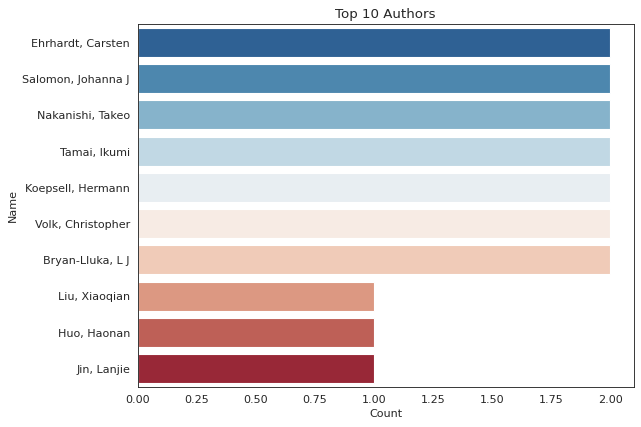

In [18]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(8, 6), dpi=80)

# Top 10 authors
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")
plt.show()


In [22]:
sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

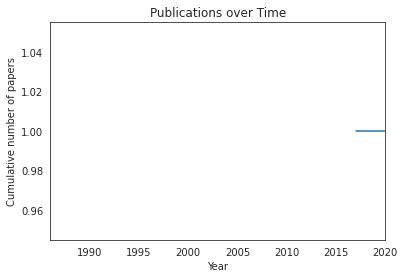

In [9]:
# Publications over Time
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.xlabel("Year")
plt.ylabel("Cumulative number of papers")
plt.title("Publications over Time")
plt.xlim([1986, 2020])
plt.show()

In [27]:
!pip install nxviz

In [34]:
from itertools import combinations
import networkx as nx
import nxviz as nv

# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.node[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


c = nv.circos(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

AttributeError: ignored

To get the most connected nodes, we will calculate two related parameters for the network: degree_centralityand betweenness_centrality. While the first is a measure of connections with respect to all possible connections of a node, the second is a measure of whether a node is part of the shortest path between two nodes. Translation in our case: who had the most collaboration and who is important in relation to other authors?

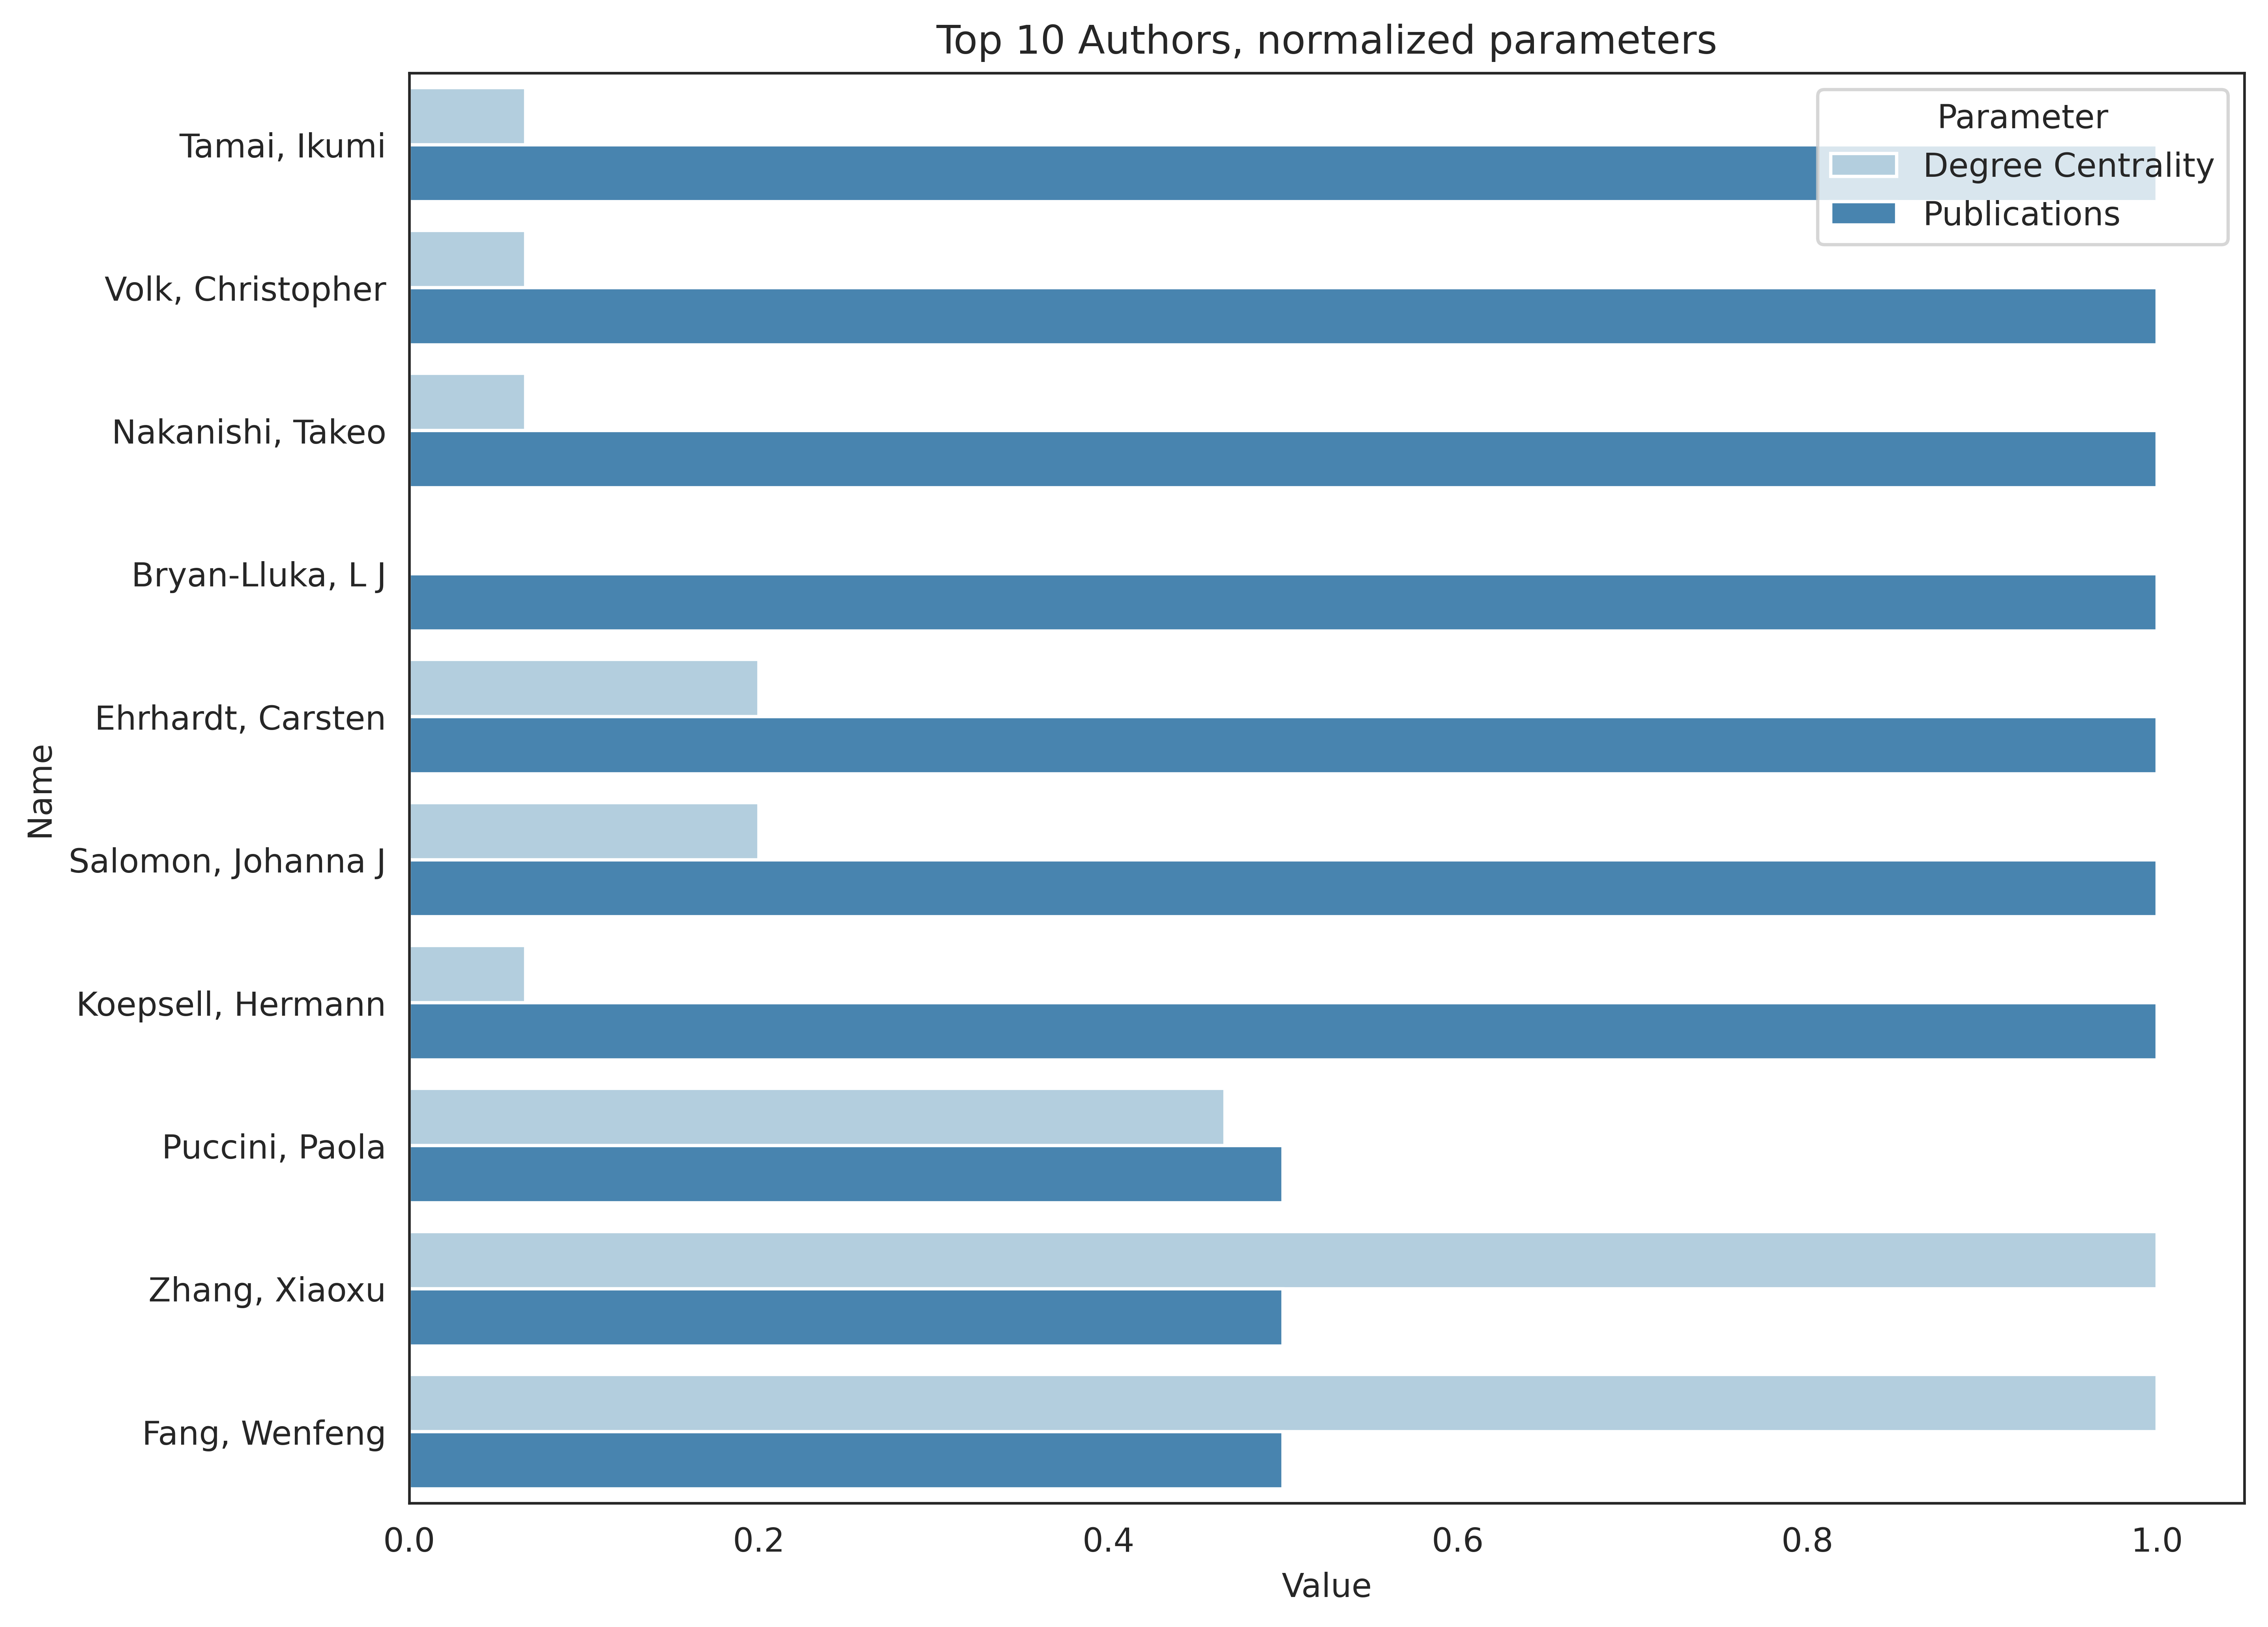

In [39]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

NodeNotFound: ignored